In [1]:
!pip install wfdb
!pip install neurokit2
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import wfdb
import mne
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D

In [4]:
NORMAL_PATHS = []
ANOMALY_PATHS = []

record_annotations = '/content/drive/MyDrive/ECG_data/records.txt'
with open(record_annotations, 'r') as file:
  records = file.readlines()
  for record in records:
    NORMAL_PATHS.append('/content/drive/MyDrive/ECG_full_normal/a_' + record.strip() + '.csv')
    ANOMALY_PATHS.append('/content/drive/MyDrive/ECG_full_anomaly/a_' + record.strip() + '.csv')


In [7]:
NORMAL_PATHS = NORMAL_PATHS[:25]
ANOMALY_PATHS = ANOMALY_PATHS[:25]
X_normal = []
for file_path in NORMAL_PATHS:
  if os.path.exists(file_path) and file_path.lower().endswith(".csv"):
        try:
            df = pd.read_csv(file_path)
            X_normal.extend(df.values.tolist()[:10000])
        except pd.errors.EmptyDataError:
            continue


X_anomaly = []
for file_path in ANOMALY_PATHS:
  if os.path.exists(file_path) and file_path.lower().endswith(".csv"):
        try:
            df = pd.read_csv(file_path)
            X_anomaly.extend(df.values.tolist()[:10000])
        except pd.errors.EmptyDataError:
            continue


In [10]:
# Подготовка данных для обучения
X = np.concatenate((X_normal, X_anomaly), axis = 0)
y = np.concatenate((np.zeros(len(X_normal)), np.ones(len(X_anomaly))), axis = 0)

def min_max_scaler(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

X_n = []
for x in X:
  X_n.append(min_max_scaler(x)[:80])

X_n = np.array(X_n)

X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.2, random_state=42)


print(X_train.shape)
print(y_train.shape)

(237278, 80)
(237278,)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(80, 1)))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 78, 32)            128       
                                                                 
 batch_normalization (Batch  (None, 78, 32)            128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 32)            3104      
                                                                 
 batch_normalization_1 (Bat  (None, 76, 32)            128       
 chNormalization)                                                
                                                                 
 max_pooling1d (MaxPooling1  (None, 38, 32)            0         
 D)                                                              
                                                        

In [12]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split = 0.1)

Epoch 1/10
6674/6674 [==============================] - 143s 21ms/step - loss: 0.4486 - accuracy: 0.7883 - val_loss: 0.4102 - val_accuracy: 0.8098
Epoch 2/10
6674/6674 [==============================] - 128s 19ms/step - loss: 0.3894 - accuracy: 0.8214 - val_loss: 0.4610 - val_accuracy: 0.7882
Epoch 3/10
6674/6674 [==============================] - 127s 19ms/step - loss: 0.3648 - accuracy: 0.8349 - val_loss: 0.3874 - val_accuracy: 0.8242
Epoch 4/10
6674/6674 [==============================] - 127s 19ms/step - loss: 0.3502 - accuracy: 0.8433 - val_loss: 0.3480 - val_accuracy: 0.8396
Epoch 5/10
6674/6674 [==============================] - 128s 19ms/step - loss: 0.3376 - accuracy: 0.8490 - val_loss: 0.3268 - val_accuracy: 0.8525
Epoch 6/10
6674/6674 [==============================] - 127s 19ms/step - loss: 0.3264 - accuracy: 0.8554 - val_loss: 0.3604 - val_accuracy: 0.8346
Epoch 7/10
6674/6674 [==============================] - 133s 20ms/step - loss: 0.3192 - accuracy: 0.8594 - val_loss: 0

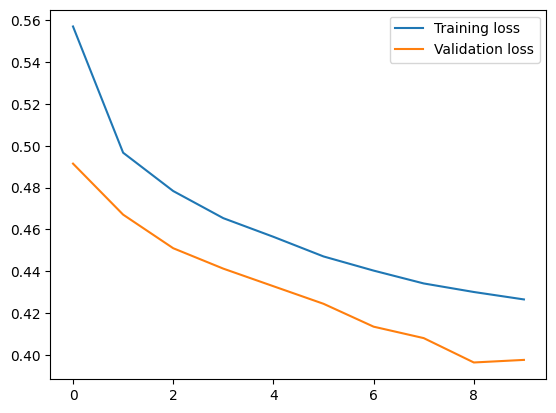

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
X_test = np.array(X_test)
print(X_test.shape)
y_pred = model.predict(X_test)

(55005, 80)
1719/1719 [==============================] - 4s 2ms/step


In [ ]:
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_test = y_test.astype(int)
print(y_test)
print(y_pred_binary)

[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 0]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      0.18      0.31     95843
           1       0.03      0.97      0.06      2760

    accuracy                           0.21     98603
   macro avg       0.51      0.58      0.19     98603
weighted avg       0.97      0.21      0.30     98603



Confusion Matrix:
[[20019  9553]
 [ 1905 23528]]
Accuracy: 0.791691664394146
Precision: 0.7112239654182159
Recall: 0.9250973145126411
F1 Score: 0.8041836141778036


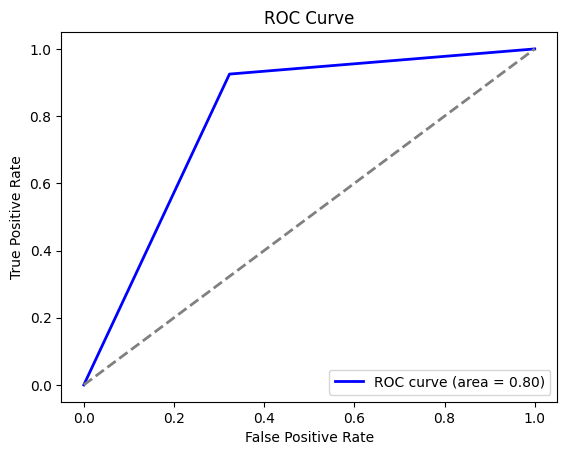

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Вычисление других метрик
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Расчет ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary)

# Расчет AUC (площади под ROC-кривой)
roc_auc = roc_auc_score(y_test, y_pred_binary)

# Построение графика ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Диагональная линия случайности
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
y_test = '/content/drive/MyDrive/ecg_full_answers/s20491.csv'
df_ans = pd.read_csv(y_test).values.flatten()
X_test = pd.read_csv('full_s20491.csv').values

In [14]:
def min_max_scaler(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

X = []
for x in X_test:
  X.append(min_max_scaler(x)[:80])

In [16]:
y_pred = model.predict(X)

3008/3008 [==============================] - 17s 6ms/step


In [17]:
from sklearn.metrics import classification_report
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_test = df_ans.astype(int)
print(y_test)
print(y_pred_binary)
print(classification_report(y_test, y_pred_binary))

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     90099
           1       0.29      0.44      0.35      6142

    accuracy                           0.89     96241
   macro avg       0.62      0.68      0.64     96241
weighted avg       0.92      0.89      0.90     96241



In [69]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Получение прогнозов на тестовых данных
#y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Преобразование вероятностей в бинарные значения
y_test = df_ans.astype(int)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)  # Balanced Accuracy
print("Balanced Accuracy:", balanced_accuracy)

# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Вычисление других метрик
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Balanced Accuracy: 0.6816213804165612
Confusion Matrix:
[[83425  6674]
 [ 3456  2686]]
Accuracy: 0.8947434045780904
Precision: 0.28696581196581195
Recall: 0.43731683490719636
F1 Score: 0.34653593084763257


In [75]:
smoothed_series = []
window_size = 3
series = y_pred_binary.flatten()
for i in range(0, len(series)):
    window = series[i:i+window_size]
    if np.count_nonzero(window == 1) >= 3:
      smoothed_series.append(1)
    else:
      smoothed_series.append(0)


In [77]:
smoothed_series_test = []
window_size = 3
series = np.array(y_test)
for i in range(0, len(series)):
    window = series[i:i+window_size]
    if np.count_nonzero(window == 1) > 0:
      smoothed_series_test.append(1/2)
    else:
      smoothed_series_test.append(0)


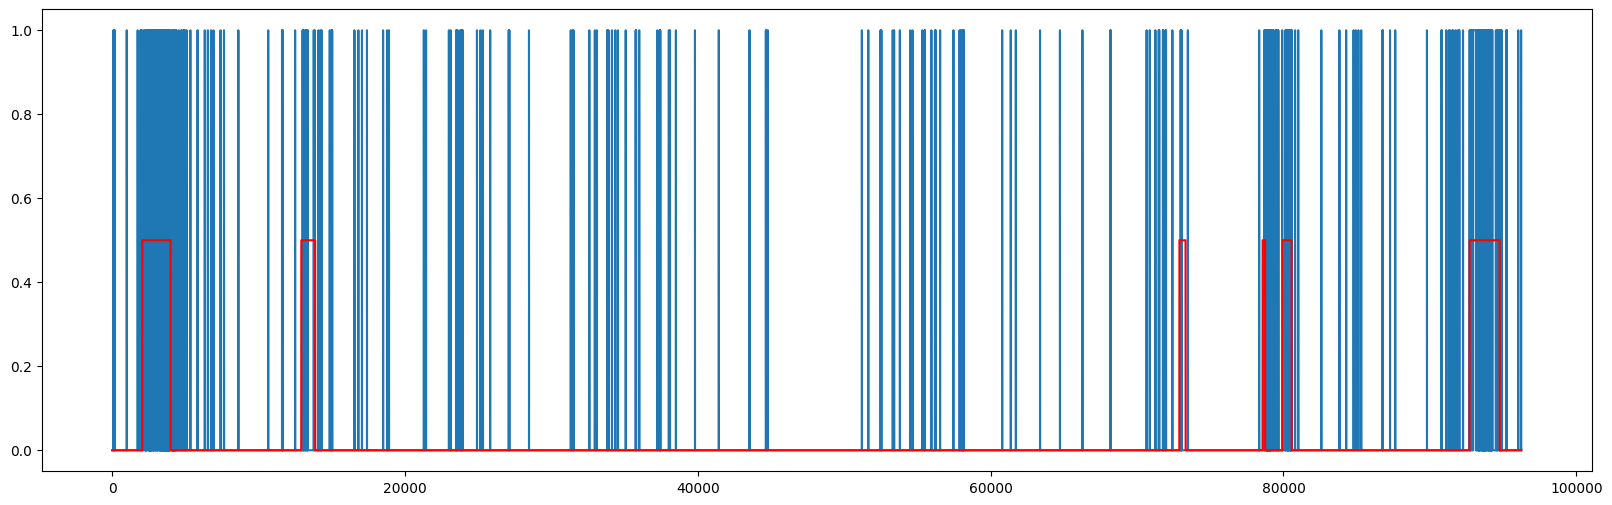

In [80]:
plt.figure(figsize=(20,6))
plt.plot(smoothed_series)
plt.plot(smoothed_series_test, color='red')
plt.show()